In [5]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools

In [ ]:
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e . 

In [7]:
from ranger import Ranger  
%cd ..

/content


In [ ]:
!pip install sam

In [116]:
from sam import sam

In [ ]:
!pip install albumentations

In [142]:
import albumentations as A

In [151]:
!pip install torchgpipe

In [153]:
from torchgpipe import GPipe

## To Do:
Now: 
* Turn on scheduler on right time.
* Try new range optimizer that works really well 
* Replace activations with Mish
https://github.com/albumentations-team/albumentations
MX Renset Source Code
https://github.com/lessw2020/mish/blob/master/mxresnet.py

In future: 
* Choose X Resnet Model with FastAI
* Try different replacements of BatchNorm
* Add Self_attention layer
* Increase Weight Decay
* Build haar cascade to cover human faces.


* Try Following 
https://forums.fast.ai/t/how-we-beat-the-5-epoch-imagewoof-leaderboard-score-some-new-techniques-to-consider/53453

Then try to apply haar cascade to white out human faces.









#### Pip Install and import other packages

In [ ]:
!pip install pytorch_lightning

In [9]:
from pytorch_lightning.metrics import Accuracy, Metric, F1, Precision, Recall, ConfusionMatrix

In [10]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [11]:
#Uncomment to load data in
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/imagewoof2-160.tgz')
my_tar.extractall() # specify which folder to extract to
my_tar.close()

In [149]:
data_dir = "/content/imagewoof2-160"
batch_size = 64
#Set random seed
np.random.seed(42)
torch.manual_seed(42)

train_transform = transforms.Compose([
                                      transforms.Resize(128),
                                      transforms.RandomCrop(128),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
                                     transforms.Resize(140),
                                     transforms.CenterCrop(128),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform = test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

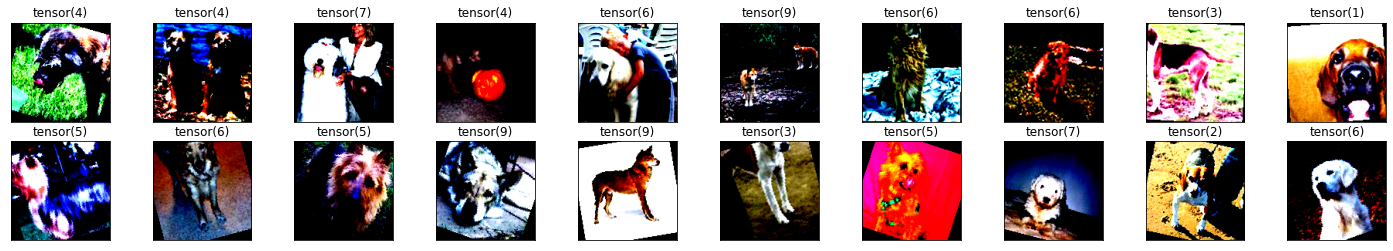

In [150]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels[idx])

In [75]:
def Graph_Maker(Train_l,Test_L, print_every):
  epoch_count = range(1, len(Train_l) + 1)
  plt.title("Loss vs. [Check Train Note]")
  plt.xlabel("Number of {} Training Batches".format(print_every))
  plt.ylabel("Loss")
  plt.plot(epoch_count,Train_l, 'r--')
  plt.plot(epoch_count,Test_L, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xticks(np.arange(1, len(Train_l)+1))
  plt.show()

In [76]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
      else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

In [139]:
def train(net, epochs, train_loader, test_loader, lr, criterion, print_every = 40, weight_decay = 0, range_optim = False, zero_base_line = False, enable_scheduler = True):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def closure(label, output):
      loss = criterion(output, label)
      loss.backward()
      return loss

    #Create metrics
    test_accuracy = Accuracy(compute_on_step = False).to(device)
    train_accuracy = Accuracy(compute_on_step = False).to(device)
    test_prec = Precision(num_classes=10, compute_on_step = False).to(device)
    test_recall = Recall(num_classes=10, compute_on_step = False).to(device)
    test_f1 = F1(num_classes=10, compute_on_step = False).to(device) 
    confmat = ConfusionMatrix(num_classes=10).to(device)

    if range_optim:
      base_optimizer = Ranger
      optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)
    else:
      optimizer = optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay)

    if enable_scheduler: 
      scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)
    
    net.to(device)
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    print("Note: Train Loss is calculated after {} batches of the train loader. While the test loss is calculated over the whole test_loader".format(print_every))
    print("For example: a sequence might be train for {} batches then test on everything and then train for the next {} batches then test on everything ... ".format(print_every, print_every))
    
    start_time = time.time()

    #For graphing
    train_list = []
    test_list = []
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        steps = 0
        
        for batch_idx, (image, label) in enumerate(train_loader):
            
            steps += 1

            if zero_base_line:
              image = torch.zeros(*image.size())

            if device == torch.device("cuda"):
                image = image.cuda()
                label = label.cuda()


            optimizer.zero_grad()
            output = net(image)
            
            loss = criterion(output, label)
            train_accuracy(output, label)
            loss.backward()
            optimizer.first_step(zero_grad = True)

            criterion(net(image), label).backward()
            optimizer.second_step(zero_grad=True)

            train_loss += loss.item()

            if (steps % print_every) == 0:

              net.eval()
              with torch.no_grad():
                test_loss = 0

                for image, label in test_loader:
                  if device == torch.device("cuda"):
                    image = image.cuda()
                    label = label.cuda()
            
                  output = net(image)
                  loss = criterion(output, label)
                  test_loss += loss.item()
                  test_accuracy(output, label)
                  if epoch == (epochs - 1):
                    test_recall(output, label)
                    test_prec(output, label)
                    test_f1(output, label)
                    confmat(output, label)
              
              # Print out metrics after every (print_every) batches
                total_test_accuracy = test_accuracy.compute()
                total_train_accuracy = train_accuracy.compute()

              for param_group in optimizer.param_groups:
                learning_rate_extract = param_group["lr"]
              print("Epoch: {}/{} | Batch Number: {} | Learning Rate: {:0.8f} | Train Loss: {:0.2f} | Train Accuracy {:0.2f}% | Test Loss: {:0.2f} | Test Accuracy {:0.2f}%".format(epoch + 1, epochs, 
                                                                                                                                                                                    steps, learning_rate_extract, 
                                                                                                                                                                                    train_loss, total_train_accuracy * 100,
                                                                                                                                                                                    test_loss, total_test_accuracy * 100))
                                                                                                                                                                                 
              #One entire test loss and one train_loss for print_every batches                                                                                                                                               
              test_list.append(test_loss)
              train_list.append(train_loss)

              assert (steps % print_every) == 0

              train_loss = 0
              net.train()
              
        if enable_scheduler:         
          scheduler.step()


    final_recall = test_recall.compute()
    final_precision = test_prec.compute()
    final_f1 = test_f1.compute()
    final_confusion_matrix = (confmat.compute()).cpu().numpy()
    print("Final Epoch Test Recall Score: {:0.2f}%".format(final_recall * 100))
    print("Final Epoch Test Precision Score: {:0.2f}%".format(final_precision * 100))
    print("Final Epoch Test F1 Score {:0.2f}%".format(final_f1 * 100))
    print("Total Time of Execution: {:0.2f} seconds".format(time.time() - start_time))

    plot_confusion_matrix(cm = final_confusion_matrix,
                          normalize = True, 
                          target_names = [str(i) for i in range(10)],
                          title = "Confusion Matrix, Normalized")

    Graph_Maker(train_list, test_list, print_every)


In [17]:
#https://stackoverflow.com/questions/55681502/label-smoothing-in-pytorch
def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss / n, nll, self.epsilon)

In [18]:
#Typical criterion for image classification
criterion = LabelSmoothingCrossEntropy()

## Build new model using LR Scheduler, Replacement of BatchNorm2d, weight decay, and more complexity in Image Processing, Cutout, Augmentations, Replace MaxPooling with something else, Also put more linear layers in the end.

First copy see if it works then read up on it!
https://github.com/albumentations-team/albumentations


Use Control f replace all with mish.
https://analyticsindiamag.com/alternatives-batch-normalization-deep-learning/
https://towardsdatascience.com/xresnet-from-scratch-in-pytorch-e64e309af722
https://www.kaggle.com/nelsongriffiths/mish-activation-and-transfer-learning-pytorch
https://docs.fast.ai/vision.models.xresnet.html#xresnext34


In [ ]:
def fcfit(learn, num_epoch=2, lr=4e-3, start_pct=.72, f_show_curve=True):
    if num_epoch<1:
        raiseValueError("num_epoch must be 1 or higher")
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*start_pct) #compute what batch to start
    batch_finish = (n*num_epoch - anneal_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    phase1 = TrainingPhase(n*5 - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    #save the setup
    learn.callbacks.append(sched)
    #start the training
    print(f"fcfit: num_epochs: {num_epoch}, lr = {lr}") 
    print(f"Flat for {anneal_start} epochs, then cosine anneal for {batch_finish}")
    learn.fit(num_epoch)
    #bonus -show lr curve?
    if f_show_curve:    
        learn.recorder.plot_lr()    

In [125]:
#Code from previous architecture
import torch.nn as nn
import torch,math,sys
import torch.utils.model_zoo as model_zoo
from functools import partial
#from ...torch_core import Module
from fastai.torch_core import Module

import torch.nn.functional as F  


class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        print("Mish activation loaded...")

    def forward(self, x): 
        
        x = x *( torch.tanh(F.softplus(x)))

        return x

# or: ELU+init (a=0.54; gain=1.55)
act_fn = Mish()#nn.ReLU(inplace=True)

__all__ = ['MXResNet', 'mxresnet18', 'mxresnet34', 'mxresnet50', 'mxresnet101', 'mxresnet152']

# or: ELU+init (a=0.54; gain=1.55)
act_fn = Mish() #nn.ReLU(inplace=True)

class Flatten(Module):
    def forward(self, x): return x.view(x.size(0), -1)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    #Apply Batchnorm on final layer
    #Apply the different subsitutes.

    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

class ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

def filt_sz(recep): return min(64, 2**math.floor(math.log2(recep*0.75)))

class MXResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=1000):
        stem = []
        sizes = [c_in,32,64,64]  #modified per Grankin
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])


Mish activation loaded...
Mish activation loaded...


In [126]:
mxresnet50 = MXResNet(4, [3, 4,  6, 3])

In [127]:
mxresnet50[10].out_features = 10

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.004
    k: 6
    lr: 0.004
    rho: 0.05
    step_counter: 0
    weight_decay: 0
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/5 | Batch Number: 40 | Learning Rate: 0.00400000 | Train Loss: 268.15 | Train Accuracy 5.74% | Test Loss: 385.46 | Test Accuracy 15.83%
Epoch: 1/5 | Batch Number: 80 | Learning Rate: 0.00400000 | Train Loss: 207.63 | Train Accuracy 20.74% | Test Loss: 297.12 | Test Accuracy 21.30%
Epoch: 1/5 | Batch Number: 120 | Learning Rate: 0.00400000 | Train Loss: 130.33 | Train Accuracy 23.67% 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 2/5 | Batch Number: 40 | Learning Rate: 0.00399998 | Train Loss: 112.24 | Train Accuracy 28.37% | Test Loss: 173.42 | Test Accuracy 30.97%
Epoch: 2/5 | Batch Number: 80 | Learning Rate: 0.00399998 | Train Loss: 108.87 | Train Accuracy 32.66% | Test Loss: 166.00 | Test Accuracy 35.40%
Epoch: 2/5 | Batch Number: 120 | Learning Rate: 0.00399998 | Train Loss: 106.37 | Train Accuracy 34.38% | Test Loss: 163.52 | Test Accuracy 37.16%
Epoch: 3/5 | Batch Number: 40 | Learning Rate: 0.00399992 | Train Loss: 102.51 | Train Accuracy 38.69% | Test Loss: 155.67 | Test Accuracy 41.82%
Epoch: 3/5 | Batch Number: 80 | Learning Rate: 0.00399992 | Train Loss: 100.36 | Train Accuracy 39.73% | Test Loss: 161.52 | Test Accuracy 38.46%
Epoch: 3/5 | Batch Number: 120 | Learning Rate: 0.00399992 | Train Loss: 99.28 | Train Accuracy 42.30% | Test Loss: 148.76 | Test Accuracy 46.22%
Epoch: 4/5 | Batch Number: 40 | Learning Rate: 0.00399982 | Train Loss: 94.97 | Train Accuracy 46.04% | Test Loss: 151.85 |

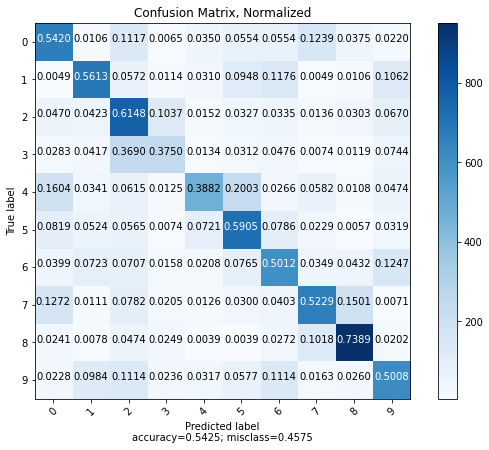

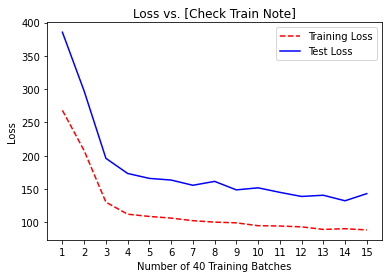

In [140]:
train(mxresnet50, 5, train_loader, test_loader, 4e-3, criterion, range_optim = True)

In [23]:
mxresnet152 = MXResNet(4, [3, 8, 36, 3])
mxresnet152[10].out_features = 10

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: Ranger (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.004
    k: 6
    lr: 0.004
    step_counter: 0
    weight_decay: 0
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/5 | Batch Number: 40 | Learning Rate: 0.00400000 | Train Loss: 265.15 | Train Accuracy 5.82% | Test Loss: 409.56 | Test Accuracy 8.98%
Epoch: 1/5 | Batch Number: 80 | Learning Rate: 0.00400000 | Train Loss: 217.91 | Train Accuracy 14.06% | Test Loss: 390.92 | Test Accuracy 13.54%
Epoch: 1/5 | Batch Number: 120 | Learning Rate: 0.00400000 | Train Loss: 145.29 | Train Accuracy 16.95% | Test Loss:

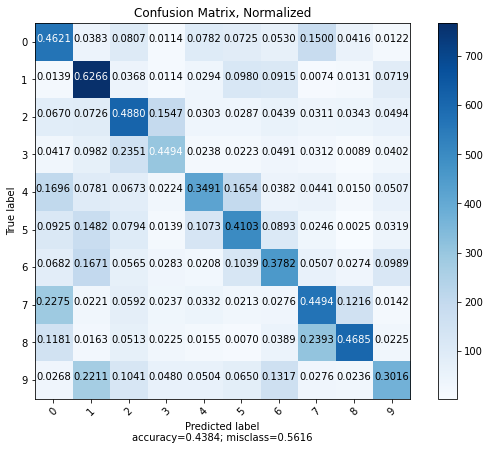

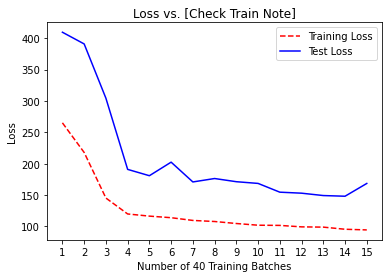

In [25]:
train(mxresnet152, 5, train_loader, test_loader, 4e-3, criterion, range_optim = True)

## Different Normalizations
https://paperswithcode.com/method/attentive-normalization
https://github.com/iVMCL/AttentiveNorm_Detection/blob/92e0084473c0a0a751b5786f3c62848eb2ba0e95/mmdet/models/backbones/aognet/operator_basic.py#L155

https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

## Attentive Normalization

In [99]:
class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out

### Feature Norm
def FeatureNorm(norm_name, num_channels, num_groups, num_k, attention_mode):
    if norm_name == "BatchNorm2d":
        return nn.BatchNorm2d(num_channels, eps=_norm_eps)
    elif norm_name == "GroupNorm":
        assert num_groups > 1
        if num_channels % num_groups != 0:
            raise ValueError("channels {} not dividable by groups {}".format(num_channels, num_groups))
        return nn.GroupNorm(num_channels, num_groups, eps=_norm_eps)
    elif norm_name == "MixtureBatchNorm2d":
        assert num_k > 1
        return MixtureBatchNorm2d(num_channels, num_k, attention_mode)
    elif norm_name == "MixtureGroupNorm":
        assert num_groups > 1 and num_k > 1
        if num_channels % num_groups != 0:
            raise ValueError("channels {} not dividable by groups {}".format(num_channels, num_groups))
        return MixtureGroupNorm(num_channels, num_groups, num_k, attention_mode)
    else:
        raise NotImplementedError("Unknown feature norm name")

### Attention weights for mixture norm
class AttentionWeights(nn.Module):
    expansion = 2
    def __init__(self, attention_mode, num_channels, k,
                norm_name=None, norm_groups=0):
        super(AttentionWeights, self).__init__()
        #num_channels *= 2
        self.k = k
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        layers = []
        if attention_mode == 0:
            layers = [ nn.Conv2d(num_channels, k, 1),
                        nn.Sigmoid() ]
        elif attention_mode == 4:
            layers = [ nn.Conv2d(num_channels, k, 1),
                        hsigmoid() ]
        elif attention_mode == 1:
            layers = [ nn.Conv2d(num_channels, k*self.expansion, 1),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(k*self.expansion, k, 1),
                        nn.Sigmoid() ]
        elif attention_mode == 2:
            assert norm_name is not None
            layers = [ nn.Conv2d(num_channels, k, 1, bias=False),
                        FeatureNorm(norm_name, k, norm_groups, 0, 0),
                        hsigmoid() ]
        elif attention_mode == 5:
            assert norm_name is not None
            layers = [ nn.Conv2d(num_channels, k, 1, bias=False),
                        FeatureNorm(norm_name, k, norm_groups, 0, 0),
                        nn.Sigmoid() ]
        elif attention_mode == 6:
            assert norm_name is not None
            layers = [ nn.Conv2d(num_channels, k, 1, bias=False),
                        FeatureNorm(norm_name, k, norm_groups, 0, 0),
                        nn.Softmax(dim=1) ]
        elif attention_mode == 3:
            assert norm_name is not None
            layers = [ nn.Conv2d(num_channels, k*self.expansion, 1, bias=False),
                        FeatureNorm(norm_name, k*self.expansion, norm_groups, 0, 0),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(k*self.expansion, k, 1, bias=False),
                        FeatureNorm(norm_name, k, norm_groups, 0, 0),
                        hsigmoid() ]
        else:
            raise NotImplementedError("Unknow attention weight type")
        self.attention = nn.Sequential(*layers)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avgpool(x)#.view(b, c)
        var = torch.var(x, dim=(2, 3)).view(b, c, 1, 1)
        y *= (var + 1e-3).rsqrt()
        #y = torch.cat((y, var), dim=1)
        return self.attention(y).view(b, self.k)

_inplace = True
_norm_eps = 1e-5

def to_int(x):
    if x - int(x) < 0.5:
        return int(x)
    else:
        return int(x) + 1

### Activation
class AC(nn.Module):
    def __init__(self, mode):
        super(AC, self).__init__()
        if mode == 1:
            self.ac = nn.LeakyReLU(inplace=_inplace)
        elif mode == 2:
            self.ac = nn.ReLU6(inplace=_inplace)
        else:
            self.ac = nn.ReLU(inplace=_inplace)

    def forward(self, x):
        x = self.ac(x)
        return x


In [100]:
class MixtureBatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_channels, k, attention_mode, eps=_norm_eps, momentum=0.1,
                 track_running_stats=True):
        super(MixtureBatchNorm2d, self).__init__(num_channels, eps=eps,
            momentum=momentum, affine=False, track_running_stats=track_running_stats)
        self.k = k
        self.weight_ = nn.Parameter(torch.Tensor(k, num_channels))
        self.bias_ = nn.Parameter(torch.Tensor(k, num_channels))

        self.attention_weights = AttentionWeights(attention_mode, num_channels, k,
                                    norm_name='BatchNorm2d')

        self._init_params()

    def _init_params(self):
        nn.init.normal_(self.weight_, 1, 0.1)
        nn.init.normal_(self.bias_, 0, 0.1)

    def forward(self, x):
        output = super(MixtureBatchNorm2d, self).forward(x)
        size = output.size()
        y = self.attention_weights(x) # bxk # or use output as attention input

        weight = y @ self.weight_ # bxc
        bias = y @ self.bias_ # bxc
        weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
        bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)

        return weight * output + bias

Device: cuda
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0003
    lr: 0.0003
    weight_decay: 0.001
)
Note: Train Loss is calculated after 40 batches of the train loader. While the test loss is calculated over the whole test_loader
For example: a sequence might be train for 40 batches then test on everything and then train for the next 40 batches then test on everything ... 
Epoch: 1/5 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 91.07 | Train Accuracy 13.05% | Test Loss: 136.00 | Test Accuracy 18.30%
Epoch: 1/5 | Batch Number: 80 | Learning Rate: 0.00030000 | Train Loss: 86.82 | Train Accuracy 19.57% | Test Loss: 132.79 | Test Accuracy 20.84%
Epoch: 1/5 | Batch Number: 120 | Learning Rate: 0.00030000 | Train Loss: 84.92 | Train Accuracy 21.09% | Test Loss: 130.86 | Test Accuracy 19.65%
Epoch: 2/5 | Batch Number: 40 | Learning Rate: 0.00030000 | Train Loss: 84.08 | Train Accuracy 20.74% | Test Loss: 12

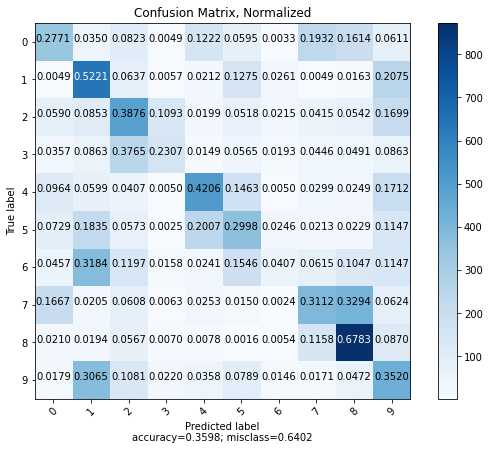

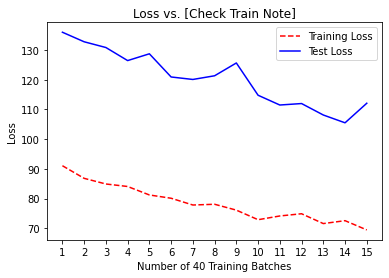

In [ ]:
train(resnet50, 5, train_loader, test_loader, 3e-4, criterion, weight_decay = 0.001)

In [ ]:
resnet50 = choose_resnet("resnet50")

### Copied the XResnet Code
https://towardsdatascience.com/xresnet-from-scratch-in-pytorch-e64e309af722

In [ ]:
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)

In [ ]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
        
    def forward(self, input):
        return (input*torch.tanh(F.softplus(input)))

def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)

def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)

def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)

def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)

def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [ ]:
activation_function = Mish()
for layer_num in range(1, 5):
  for ii, bottleneck in enumerate(eval("resnet50.layer{}".format(layer_num))):
    locals()[eval("resnet50.layer{}{}.relu".format(layer_num, [ii]))] = activation_function 
    

ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
ReLU(inplace=True)
